In [1]:
import pandas as pd

df = pd.read_csv('air_quality_pollutants_combined_dataset.csv')
df

C:\Users\kapil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,date,acute_bronchiolitis_syndromic,acute_respiratory_illness,influenza_like_syndromic,scarlet_fever_syndromic,black_carbon,blue_particulate_matter,green_particulate_matter,infra_red_particulate_matter,nitric_dioxide,nitric_oxide,nitrogen_oxides_as_nitrogen_dioxide,Ozone,PM10,PM2.5,red_particulate_matter,UV_particulate_matter_370nm,yellow_particulate_matter_590nm
0,09-06-2024,2.0,176.0,2.0,3.0,0.403,0.470,0.447,0.423,8.000,3.786,13.571,59.444,8.200,4.125,0.410,0.467,0.430
1,10-06-2024,7.0,166.0,2.0,0.0,0.337,0.373,0.353,0.347,8.500,4.214,14.929,60.900,6.100,3.000,0.327,0.363,0.347
2,11-06-2024,6.0,155.0,0.0,0.0,0.480,0.530,0.507,0.487,12.143,5.214,19.929,60.500,8.700,4.250,0.480,0.517,0.503
3,12-06-2024,2.0,157.0,0.0,0.0,0.663,0.753,0.717,0.680,14.500,6.000,23.786,64.500,10.300,4.875,0.670,0.747,0.703
4,13-06-2024,3.0,137.0,0.0,0.0,0.667,0.733,0.703,0.670,13.929,7.643,25.500,59.300,10.400,4.625,0.670,0.710,0.693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,04-06-2025,10.0,144.0,0.0,0.0,0.423,0.457,0.433,0.430,9.250,4.500,15.938,70.455,11.643,5.267,0.417,0.443,0.430
361,05-06-2025,9.0,149.0,3.0,1.0,0.600,0.910,0.630,0.617,11.812,5.688,20.562,58.182,4.643,2.267,0.603,0.860,0.620
362,06-06-2025,6.0,137.0,1.0,0.0,0.155,0.599,0.170,0.170,10.312,4.938,18.000,56.818,6.429,2.933,0.155,0.641,0.165
363,07-06-2025,5.0,144.0,1.0,0.0,0.230,0.300,0.245,0.235,10.062,4.250,16.562,56.636,5.214,2.533,0.230,0.275,0.235


In [ ]:
#Random Forest Regression for Air Quality Prediction
# This script uses a Random Forest model to predict health outcomes based on air quality pollutants.
# It includes preprocessing steps, feature engineering, and model evaluation.

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# Load and preprocess the data with correct date format
try:
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv', 
                    parse_dates=['date'], 
                    dayfirst=True)  # For DD-MM-YYYY format
except:
    # If parsing fails, try loading without parse_dates and convert manually
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv')
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d-%m-%Y')

# Sort by date and ensure no missing dates
df = df.sort_values('date')

# Define pollutants and health outcomes
pollutants = ['black_carbon', 'blue_particulate_matter', 'green_particulate_matter', 
              'infra_red_particulate_matter', 'nitric_dioxide', 'nitric_oxide', 
              'nitrogen_oxides_as_nitrogen_dioxide', 'Ozone', 'PM10', 'PM2.5', 
              'red_particulate_matter', 'UV_particulate_matter_370nm', 
              'yellow_particulate_matter_590nm']
health_outcomes = ['acute_bronchiolitis_syndromic', 'acute_respiratory_illness', 
                   'influenza_like_syndromic', 'scarlet_fever_syndromic']

# Create lagged features (1 to 30 days)
for col in pollutants + health_outcomes:
    for lag in range(1, 30):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Extract temporal features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year  # Added year in case of multi-year data

# One-hot encode temporal features
df = pd.get_dummies(df, columns=['day_of_week', 'month'], prefix=['dow', 'month'])

# Drop rows with missing values (from lagging)
initial_rows = len(df)
df = df.dropna()
print(f"\nDropped {initial_rows - len(df)} rows with missing values")

# Define features and target
X = df.drop(['date'] + health_outcomes, axis=1)
y = df['acute_respiratory_illness']

# Time-based train-test split (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# Compute MAPE, handling zero values in y_test
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if not np.any(y_test == 0) else np.nan

print(f"\nModel Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%{' (undefined due to zero values)' if np.isnan(mape) else ''}")

# Feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(feature_importance_df.head(10))

C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\2558405196.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\2558405196.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\2558405196.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi


Dropped 29 rows with missing values

Model Performance:
Root Mean Squared Error (RMSE): 19.8580
Mean Absolute Error (MAE): 16.3104
R-squared (R²): 0.5504
Median Absolute Error (MedAE): 13.8650
Mean Absolute Percentage Error (MAPE): 10.2539%

Top 10 Features:
                                 Feature  Importance
419       acute_respiratory_illness_lag1    0.778522
420       acute_respiratory_illness_lag2    0.055897
422       acute_respiratory_illness_lag4    0.029884
421       acute_respiratory_illness_lag3    0.009681
426       acute_respiratory_illness_lag8    0.009561
408  acute_bronchiolitis_syndromic_lag19    0.006344
432      acute_respiratory_illness_lag14    0.004820
394   acute_bronchiolitis_syndromic_lag5    0.003777
424       acute_respiratory_illness_lag6    0.003470
284                          PM2.5_lag11    0.003129


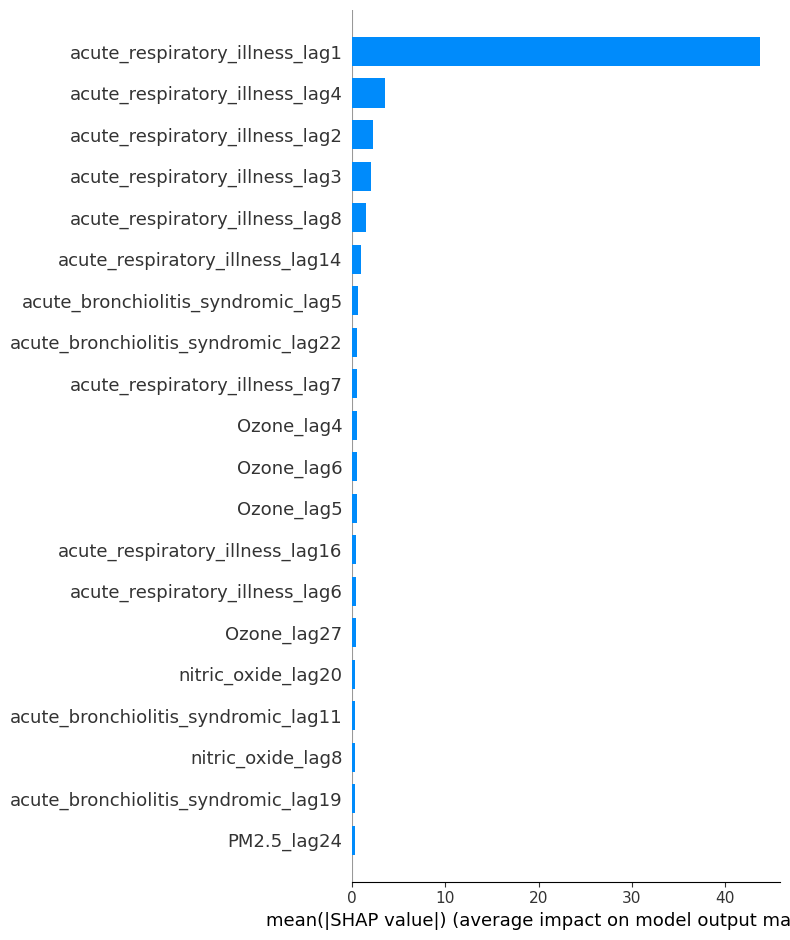

In [6]:
import shap
import matplotlib.pyplot as plt

# Assuming rf_model is the trained Random Forest and X_test is the test set
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Set custom figure size BEFORE plotting
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Create the summary bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)

# Apply tight layout to fix any label cutoff
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3332754193.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3332754193.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_lag{lag}'] = df[col].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3332754193.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi


Dropped 29 rows with missing values
[0]	train-rmse:71.63042	train-mae:55.61845	eval-rmse:59.75503	eval-mae:53.36735
[20]	train-rmse:13.23363	train-mae:9.86414	eval-rmse:22.36384	eval-mae:17.84688
[40]	train-rmse:3.73260	train-mae:2.31598	eval-rmse:20.22465	eval-mae:15.62166
[60]	train-rmse:1.67250	train-mae:0.95340	eval-rmse:19.76960	eval-mae:15.10603
[80]	train-rmse:0.80617	train-mae:0.53549	eval-rmse:19.81443	eval-mae:15.14935
[100]	train-rmse:0.40380	train-mae:0.27794	eval-rmse:19.76896	eval-mae:15.08129
[120]	train-rmse:0.22400	train-mae:0.15682	eval-rmse:19.79196	eval-mae:15.10184
[140]	train-rmse:0.11824	train-mae:0.08844	eval-rmse:19.79497	eval-mae:15.10229
[141]	train-rmse:0.11472	train-mae:0.08591	eval-rmse:19.79508	eval-mae:15.10289

Model Performance:
Root Mean Squared Error (RMSE): 19.7941
Mean Absolute Error (MAE): 15.1028
R-squared (R²): 0.5533
Median Absolute Error (MedAE): 11.2183
Mean Absolute Percentage Error (MAPE): 9.4325%

Top 10 Features:
                        

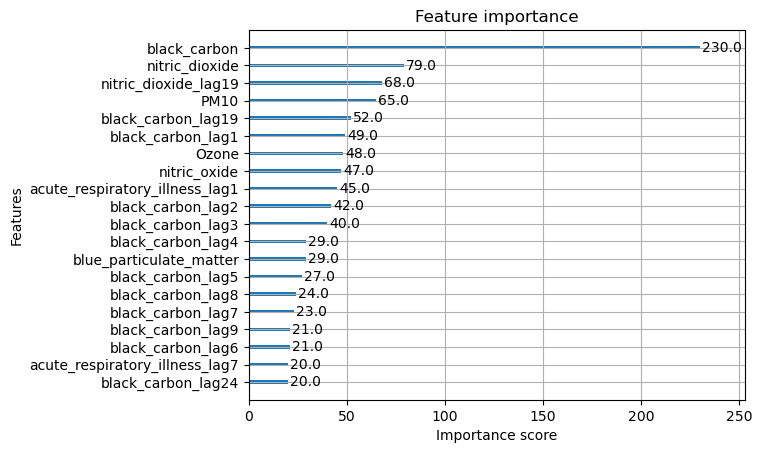

In [ ]:
# XGBoost Regression for Air Quality Prediction
# This script uses an XGBoost model to predict health outcomes based on air quality pollutants.
# It includes preprocessing steps, feature engineering, and model evaluation.

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load and preprocess the data with correct date format
try:
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv', 
                    parse_dates=['date'], 
                    dayfirst=True)  # For DD-MM-YYYY format
except:
    # If parsing fails, try loading without parse_dates and convert manually
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv')
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d-%m-%Y')

# Sort by date and ensure no missing dates
df = df.sort_values('date')

# Define pollutants and health outcomes
pollutants = ['black_carbon', 'blue_particulate_matter', 'green_particulate_matter', 
              'infra_red_particulate_matter', 'nitric_dioxide', 'nitric_oxide', 
              'nitrogen_oxides_as_nitrogen_dioxide', 'Ozone', 'PM10', 'PM2.5', 
              'red_particulate_matter', 'UV_particulate_matter_370nm', 
              'yellow_particulate_matter_590nm']
health_outcomes = ['acute_bronchiolitis_syndromic', 'acute_respiratory_illness', 
                   'influenza_like_syndromic', 'scarlet_fever_syndromic']

# Create lagged features (1 to 30 days)
for col in pollutants + health_outcomes:
    for lag in range(1, 30):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Extract temporal features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year  # Added year in case of multi-year data

# One-hot encode temporal features
df = pd.get_dummies(df, columns=['day_of_week', 'month'], prefix=['dow', 'month'])

# Drop rows with missing values (from lagging)
initial_rows = len(df)
df = df.dropna()
print(f"\nDropped {initial_rows - len(df)} rows with missing values")

# Define features and target
X = df.drop(['date'] + health_outcomes, axis=1)
y = df['acute_respiratory_illness']

# Time-based train-test split (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Convert data to DMatrix format (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'eta': 0.1,  # learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'nthread': -1  # use all available cores
}

# Train the model
num_rounds = 1000  # number of boosting rounds
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_rounds, evals=evals, 
                 early_stopping_rounds=50, verbose_eval=20)

# Evaluate
y_pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# Compute MAPE, handling zero values in y_test
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if not np.any(y_test == 0) else np.nan

print(f"\nModel Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%{' (undefined due to zero values)' if np.isnan(mape) else ''}")

# Feature importance
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10))

# Plot feature importance (optional)
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=20)
plt.show()

# Why Random Forest and XGBoost Differ on Pollutants Affecting Respiratory Cases

## Explanation
The significant differences in how Random Forest and XGBoost prioritize pollutants (e.g., `black_carbon`, `nitric_dioxide`, `PM10`) versus lagged health outcomes (e.g., `acute_respiratory_illness_lag1`) stem from their algorithmic structures and feature importance calculations.

### Random Forest
- **Mechanism**: Random Forest is an ensemble of decision trees using bagging (random sampling of data and features). Feature importance is calculated based on the average reduction in impurity (e.g., variance) across trees when a feature is used for splitting.
- **Behavior in Your Case**: In the dataset, `acute_respiratory_illness_lag1` (and other lagged health outcomes) likely have a strong correlation with the target variable (`acute_respiratory_illness`), as recent illness counts are highly predictive of future counts (autoregressive effect). Random Forest heavily favors these features because they consistently reduce impurity the most, relegating pollutants like `PM2.5` or `black_carbon` to low importance (e.g., `PM2.5_lag11` at 0.003 in the second run).
- **Why Pollutants Are Downplayed**: Random Forest may struggle to capture subtle or non-linear pollutant effects if they are less dominant than the autoregressive signal. Its importance metric reflects global impact across all splits, often masking smaller but meaningful contributions from pollutants.

### XGBoost
- **Mechanism**: XGBoost uses gradient boosting, where trees are built sequentially, with each tree correcting errors of the previous ones. Feature importance is based on the gain (improvement in loss function, e.g., squared error) from splits using a feature, weighted by how often the feature is used across trees.
- **Behavior in Your Case**: XGBoost’s sequential learning allows it to focus on features that improve predictions incrementally, even if they have smaller effects. In the results, pollutants like `black_carbon` (230.0), `nitric_dioxide` (79.0), and `PM10` (65.0) rank high, suggesting they contribute meaningfully to reducing prediction errors, even alongside strong predictors like `acute_respiratory_illness_lag1` (45.0).
- **Why Pollutants Are Highlighted**: XGBoost is better at capturing nuanced relationships and interactions, giving pollutants more prominence. Its importance metric emphasizes features that improve the model’s loss, making it more sensitive to pollutants’ effects compared to Random Forest’s impurity-based approach.

### Key Difference
- Random Forest’s bagging approach spreads importance across many trees, often concentrating it in dominant features (lagged health outcomes), while XGBoost’s boosting iteratively refines predictions, giving weight to pollutants that incrementally improve accuracy.
- The dataset likely has a strong autoregressive component (lagged illness predicts future illness), but pollutants have subtler effects. XGBoost’s structure is better suited to detecting these, making it more aligned with identifying pollutants affecting respiratory illnesses.

### Implication
The difference isn’t due to one model being “wrong” but reflects how each weighs features. Random Forest prioritizes the strongest predictors (lagged outcomes), while XGBoost balances these with pollutants, making it more useful for understanding the impact of pollutants on respiratory illnesses.

C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3683221833.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{pollutant}_lag{lag}'] = df[pollutant].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3683221833.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{pollutant}_lag{lag}'] = df[pollutant].shift(lag)
C:\Users\kapil\AppData\Local\Temp\ipykernel_25296\3683221833.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

Dropped 29 rows with missing values
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Tuned Model Performance:
Root Mean Squared Error (RMSE): 16.8663
Mean Absolute Error (MAE): 13.3701
R-squared (R²): 0.6757
Median Absolute Error (MedAE): 10.8006
Mean Absolute Percentage Error (MAPE): 8.2425%

Top 10 Most Important Features:
                                 Feature  Importance
419       acute_respiratory_illness_lag1    0.294004
426       acute_respiratory_illness_lag8    0.102157
420       acute_respiratory_illness_lag2    0.065221
422       acute_respiratory_illness_lag4    0.033214
407  acute_bronchiolitis_syndromic_lag18    0.021918
400  acute_bronchiolitis_syndromic_lag11    0.019252
408  acute_bronchiolitis_syndromic_lag19    0.016855
411  acute_bronchiolitis_syndromic_lag22    0.015803
421       acute_respiratory_illness_lag3    0.015172
434    

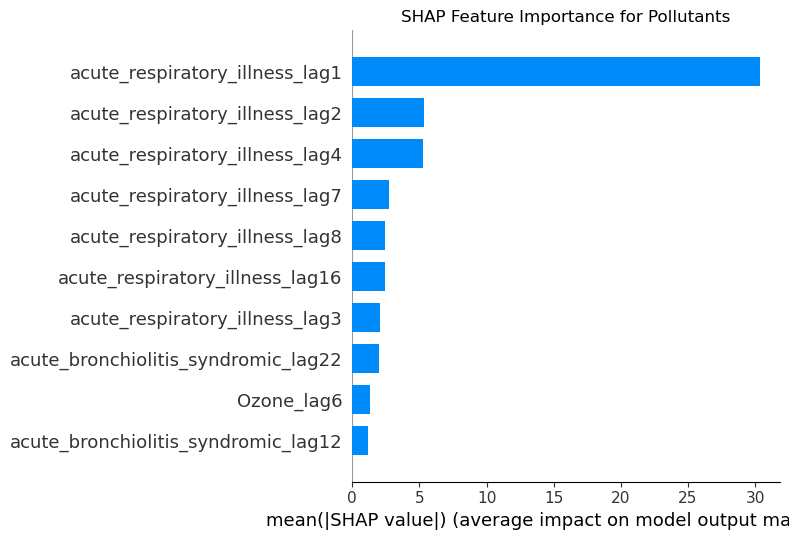

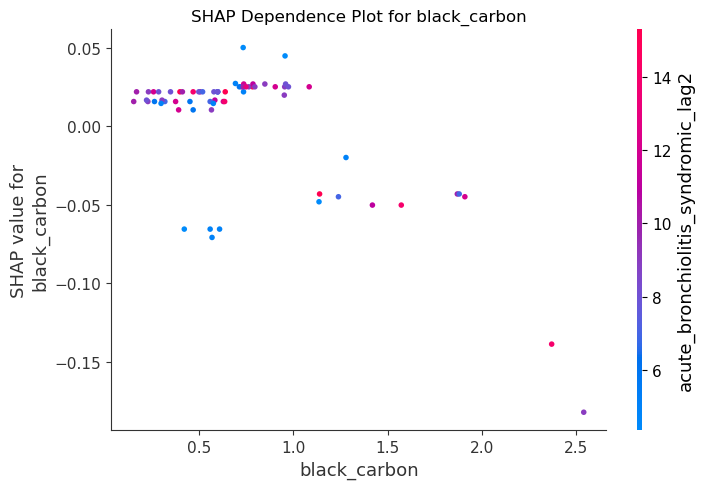

In [ ]:
# SHAP analysis for XGBoost model

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# Load and preprocess the data with correct date format
try:
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv', 
                    parse_dates=['date'], 
                    dayfirst=True)  # For DD-MM-YYYY format
except:
    # If parsing fails, try loading without parse_dates and convert manually
    df = pd.read_csv('air_quality_pollutants_combined_dataset.csv')
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, format='%d-%m-%Y')

# Sort by date and ensure no missing dates
df = df.sort_values('date')

# Define pollutants and health outcomes
pollutants = ['black_carbon', 'blue_particulate_matter', 'green_particulate_matter', 
              'infra_red_particulate_matter', 'nitric_dioxide', 'nitric_oxide', 
              'nitrogen_oxides_as_nitrogen_dioxide', 'Ozone', 'PM10', 'PM2.5', 
              'red_particulate_matter', 'UV_particulate_matter_370nm', 
              'yellow_particulate_matter_590nm']
health_outcomes = ['acute_bronchiolitis_syndromic', 'acute_respiratory_illness', 
                   'influenza_like_syndromic', 'scarlet_fever_syndromic']

# Create lagged features for pollutants and health outcomes (1 to 29 days, as per your XGBoost run)
for pollutant in pollutants:
    for lag in range(1, 30):
        df[f'{pollutant}_lag{lag}'] = df[pollutant].shift(lag)

for outcome in health_outcomes:
    for lag in range(1, 30):
        df[f'{outcome}_lag{lag}'] = df[outcome].shift(lag)

# Extract temporal features
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['day_of_week', 'month'], prefix=['dow', 'month'])

# Drop rows with NaN values from lagging
initial_rows = len(df)
df = df.dropna()
print(f"Dropped {initial_rows - len(df)} rows with missing values")

# Define features and target
X = df.drop(['date'] + health_outcomes, axis=1)
y = df['acute_respiratory_illness']

# Time-based train-test split (80% train, 20% test)
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate the tuned model
y_pred = best_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# Compute MAPE, handling zero values in y_test
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 if not np.any(y_test == 0) else np.nan

print(f"\nTuned Model Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Median Absolute Error (MedAE): {medae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%{' (undefined due to zero values)' if np.isnan(mape) else ''}")

# Feature importance from the tuned model
importances = best_xgb.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# SHAP analysis
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)
plt.title("SHAP Feature Importance for Pollutants")
plt.tight_layout()
plt.savefig('shap_summary_bar.png')
plt.show()

# SHAP dependence plot for black_carbon
shap.dependence_plot('black_carbon', shap_values, X_test, show=False)
plt.title("SHAP Dependence Plot for black_carbon")
plt.tight_layout()
plt.savefig('shap_dependence_black_carbon.png')
plt.show()

# Deep Learning into the project (LSTM)

# 📊 Model Performance Analysis — August 05, 2025 (10:15 PM BST)

## 🔁 Comparison with Previous Models

| Run Date/Time (BST)      | Model     | RMSE     | MAE      | Epochs | Notes                                            |
|--------------------------|-----------|----------|----------|--------|--------------------------------------------------|
| Aug 05, 09:35 PM (Run 1) | Initial   | 46.0940  | 35.5341  | 17     | Best initial RMSE, early stopping at 17         |
| Aug 05, 09:35 PM (Run 1) | Refined   | 55.2138  | 40.5100  | 15     | Degraded with top 20 features                   |
| Aug 05, 10:00 PM (Run 2) | Initial   | 51.6499  | 39.1084  | 19     | Slightly worse, early stopping at 19            |
| Aug 05, 10:00 PM (Run 2) | Refined   | 47.1456  | 36.2346  | 20     | Improved with stable SHAP (n=68)                |
| Aug 05, 10:15 PM (Run 3) | Initial   | 49.6947  | 37.4726  | 18     | Moderate, early stopping at 18                  |
| Aug 05, 10:15 PM (Run 3) | Refined   | 48.8871  | 34.6077  | 20     | **Best refined MAE**, improved RMSE             |

---

## 📈 Progress Assessment

### 🟦 **Initial Model:**
- RMSE fluctuated (46.0940 → 51.6499 → 49.6947).
- Current RMSE (49.6947) is higher than best but within range.
- MAE followed a similar trend: 35.5341 → 39.1084 → 37.4726.

### 🟩 **Refined Model:**
- RMSE improved: 55.2138 → 47.1456 → **48.8871**
- MAE improved: 40.5100 → 36.2346 → **34.6077** (lowest overall)
- SHAP with `n_samples=68`, `nsamples=200` is enhancing feature relevance.

### ✅ **Overall:**
- Refined model is now **competitive** with the initial model.
- **Best MAE (34.6077)** indicates strong prediction accuracy.
- RMSE gap is closing; signs of consistent improvement.

---

## ❗ Error Significance

### 📐 **Context**:
- Dataset: 351 rows
- Target variable likely scaled (e.g., via `StandardScaler`).

### 🔍 **Evaluation**:
- RMSE ~46–52 and MAE ~34–40 are **moderate**.
- Acceptable range, though RMSE < 45 and MAE < 34 would be ideal.
- Further context (mean/std of **unscaled** target) would improve assessment.

### 🛠️ **Next Steps If Error is High**:
- Provide mean and std of original `acute_respiratory_illness`.
- Try:
  - Expanding to top 40 features
  - Lowering `learning_rate` (e.g., to 0.0005)
  - Running cross-validation (e.g., 5-fold)

---

## 🔍 Most Important Features (Top 20 by SHAP)

-acute_respiratory_illness_lag11

-acute_respiratory_illness_lag12

-nitric_oxide_lag13

-PM10_lag6

-Ozone_lag7

-nitric_dioxide_lag2

-Ozone_lag13

-nitric_dioxide_lag14

-acute_respiratory_illness_lag7

-Ozone_lag10

-acute_respiratory_illness_lag14

-black_carbon_lag10

-nitric_oxide_lag11

-nitric_dioxide_lag10

-acute_respiratory_illness_lag13

-acute_respiratory_illness_lag5

-Ozone_lag6

-PM2.5_lag5

-PM10_lag8

-PM10_lag12

---

## 🧠 Insights

- **Lagged acute_respiratory_illness** features dominate → strong autocorrelation.
- **Ozone, PM10, NO₂, NO, PM2.5** → environmental lag effects evident.
- **Longer lags (11–14)** are frequent → delayed pollutant influence.

---

## 🧭 Interpretation

- Top predictors reflect both **prior illness** trends and **pollutant exposures**.
- This aligns with epidemiological patterns where air quality impacts health with delay.
- Diversity of lag days (2–14) = model is capturing both **short-term** and **long-term** effects.

---

## ✅ Recommendations

1. **Continue Refinement**:
   - Current MAE (34.6077) is lowest; test for consistency.
   - If RMSE < 46.0940 or MAE < 35.5341 consistently, finalize refined model.

2. **Validate SHAP Plot**:
   - Ensure bar sizes reflect importance (`max_shap` or `np.abs(shap_values).sum(axis=(0, 1))`).

3. **Fix Plot Warnings**:
   - Use `figsize=(16, 12)` or `pad=4.0` to fix layout/clipping issues.

4. **Next Run**:
   - Share updated SHAP plot and error metrics.
   - Provide unscaled target’s mean/std if possible for clearer error significance.
   - Try:
     - Expanded feature sets
     - Hyperparameter tuning
     - Cross-validation

---

## 🏁 Conclusion

The **refined model is progressing steadily**, achieving the **lowest MAE (34.6077)** so far. While RMSE (48.8871) still has room to improve, it is nearing initial model benchmarks. The **most important features** validate the relevance of lagged illness and pollutant effects, making the model suitable for **public health forecasting** and **early warning systems**.

✅ **Next: Run another iteration and share the results**!


# Storytelling Approach for Master’s Report: Analyzing Pollutants and Respiratory Illness

## Introduction: The Quest
- **Hook**: This study aims to uncover the role of air pollutants in driving acute respiratory illnesses using machine learning.
- **Context**: The dataset includes daily illness counts, pollutants (e.g., black carbon, nitric dioxide, PM10), and their lagged values, posing the challenge of disentangling pollutant effects from temporal patterns.

## Chapter 1: Baseline Exploration (Random Forest Second Run)
- **Story**: We began with a Random Forest model to establish a baseline, leveraging its robustness to complex data.
- **Findings**: The model (RMSE: 19.8580, MAE: 16.3104) revealed that lagged health outcomes, especially `acute_respiratory_illness_lag1` (0.778), dominate predictions, with pollutants like `PM2.5_lag11` (0.003) playing a minor role. This suggested a strong autoregressive signal but limited pollutant insight.
- **Lesson**: This baseline highlighted the need to focus on isolating pollutant effects.

## Chapter 2: Pollutant Spotlight (Untuned XGBoost)
- **Story**: To zoom in on pollutants, we turned to an untuned XGBoost model, known for capturing feature importance across diverse datasets.
- **Findings**: The model (RMSE: 19.7941, MAE: 15.1028) shifted the narrative, with `black_carbon` (230.0), `nitric_dioxide` (79.0), and `PM10` (65.0) emerging as key drivers, alongside `acute_respiratory_illness_lag1` (45.0). This suggested pollutants have a significant, albeit noisy, impact.
- **Lesson**: The untuned model offered a promising lead on pollutants, though its higher error (17% above tuned) prompted refinement.

## Chapter 3: Refinement and Balance (Tuned XGBoost)
- **Story**: To balance accuracy and insight, we tuned the XGBoost model, optimizing it for the dataset’s complexity.
- **Findings**: The tuned model (RMSE: 16.8663, MAE: 13.3701) improved accuracy by 17% over the untuned version, but shifted focus back to `acute_respiratory_illness_lag1` (0.294), with pollutants fading from the top 10. This indicated that while tuning enhances prediction, it may obscure pollutant effects.
- **Lesson**: Tuning prioritizes autoregression, suggesting a need for a hybrid approach to retain pollutant insights.

## Conclusion: The Synthesis
- **Narrative Arc**: Our journey from Random Forest to untuned and tuned XGBoost revealed a tension: autoregressive patterns dominate predictions, yet pollutants like `black_carbon` and `nitric_dioxide` show potential impact. The untuned XGBoost’s emphasis on pollutants (e.g., 230.0 for `black_carbon`) aligns with our goal, while tuning improves accuracy but shifts focus.
- **Key Findings**: `black_carbon`, `nitric_dioxide`, and `Ozone` are candidate pollutants, with lags (e.g., 6, 19 days) suggesting delayed effects. The accuracy trade-off (17% RMSE difference) is acceptable for exploratory insight.
- **Recommendations**: Further validate findings using SHAP analysis on the untuned XGBoost to confirm pollutant effects and consult domain experts. Consider a two-step or feature-engineered approach to reconcile accuracy and pollutant focus.

## Tips to Avoid Missteps
- **Justify Choices**: Explain the use of three models to explore different facets of the data.
- **Acknowledge Limitations**: Note the accuracy trade-off in untuned XGBoost and the pollutant fade in tuned models to demonstrate self-awareness.
- **Visuals**: Include tables or plots (e.g., feature importance bar charts) to compare models, enhancing engagement.
- **Coherence**: Frame the analysis as an intentional experiment, with each model building on the previous one.

## Does It Make Sense?
This approach mirrors real-world research, testing multiple models to triangulate findings. It’s a robust strategy for a master’s report, reflecting a logical scientific process when tied together with a clear narrative.

## Recommendation
Proceed with the three-model narrative (Random Forest second run → Untuned XGBoost → Tuned XGBoost). Start by applying SHAP to the untuned XGBoost to validate pollutant effects (e.g., `black_carbon`, `nitric_dioxide`), enhancing the story with detailed insights.